In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar 10 18:55:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Import Stuff here

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import time
from datetime import datetime
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [ ]:
from google.colab import drive, files

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#creates a Image Generator from the directories and scales the images by dividing by 255. Also changes the images sizes to 256x256

def load_data():

    datagen = ImageDataGenerator(rescale = 1/255)
    
    train_it = datagen.flow_from_directory ('/content/drive/My Drive/Colab Notebooks/IFFI-dataset-raw/train/', target_size = (256, 256), 
                                            class_mode = 'categorical', color_mode="rgb", batch_size=64, seed = 1)
    
    val_it = datagen.flow_from_directory ('/content/drive/My Drive/Colab Notebooks/IFFI-dataset-raw/validation/', target_size = (256, 256), 
                                            class_mode = 'categorical', color_mode="rgb", batch_size=64, seed = 1)
    
    test_it = datagen.flow_from_directory ('/content/drive/My Drive/Colab Notebooks/IFFI-dataset-raw/test/', target_size = (256, 256), 
                                            class_mode = 'categorical', color_mode="rgb", batch_size=64, seed = 1,  shuffle=False)
    
    return train_it, val_it, test_it

train_it, val_it, test_it = load_data()

Found 6800 images belonging to 17 classes.
Found 1700 images belonging to 17 classes.
Found 1700 images belonging to 17 classes.


In [ ]:
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 256, 256, 3), min=0.000, max=1.000


In [ ]:
train_it.class_indices

{'1977': 0,
 'Amaro': 1,
 'Brannan': 2,
 'Clarendon': 3,
 'Gingham': 4,
 'He-Fe': 5,
 'Hudson': 6,
 'Lo-Fi': 7,
 'Mayfair': 8,
 'Nashville': 9,
 'Original': 10,
 'Perpetua': 11,
 'Sutro': 12,
 'Toaster': 13,
 'Valencia': 14,
 'Willow': 15,
 'X-ProII': 16}

In [ ]:
nclass = len(train_it.class_indices)

base_model = InceptionV3(input_shape = (299, 299, 3), # Shape of our images
                          include_top = False, # Leave out the last fully connected Layer
                          weights = 'imagenet',
                          classes = nclass)
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 17)                34833     
                                                                 
Total params: 21,837,617
Trainable params: 34,833
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
def compile_model(model):
  
  model.compile(optimizer = 'Adam',
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=['AUC', 'accuracy'])
  
  return model

def train_model(model, train_it, val_it):
    history = model.fit(train_it, epochs = 24, steps_per_epoch = 107, verbose = 2, validation_data= val_it, validation_steps = 27)
    return model, history
 
model = compile_model(model)

model, history = train_model(model, train_it, val_it)
print (model.summary())

Epoch 1/24
107/107 - 2486s - loss: 3.2960 - auc: 0.5471 - accuracy: 0.0938 - val_loss: 2.6514 - val_auc: 0.6572 - val_accuracy: 0.1765 - 2486s/epoch - 23s/step
Epoch 2/24
107/107 - 213s - loss: 2.8953 - auc: 0.6372 - accuracy: 0.1532 - val_loss: 2.4886 - val_auc: 0.7226 - val_accuracy: 0.2071 - 213s/epoch - 2s/step
Epoch 3/24
107/107 - 213s - loss: 2.7459 - auc: 0.6774 - accuracy: 0.1791 - val_loss: 2.3975 - val_auc: 0.7507 - val_accuracy: 0.2418 - 213s/epoch - 2s/step
Epoch 4/24
107/107 - 215s - loss: 2.6296 - auc: 0.7047 - accuracy: 0.1990 - val_loss: 2.4265 - val_auc: 0.7439 - val_accuracy: 0.2329 - 215s/epoch - 2s/step
Epoch 5/24
107/107 - 213s - loss: 2.5462 - auc: 0.7254 - accuracy: 0.2209 - val_loss: 2.3827 - val_auc: 0.7592 - val_accuracy: 0.2365 - 213s/epoch - 2s/step
Epoch 6/24
107/107 - 213s - loss: 2.4944 - auc: 0.7403 - accuracy: 0.2309 - val_loss: 2.3292 - val_auc: 0.7734 - val_accuracy: 0.2388 - 213s/epoch - 2s/step
Epoch 7/24
107/107 - 214s - loss: 2.4584 - auc: 0.7475 

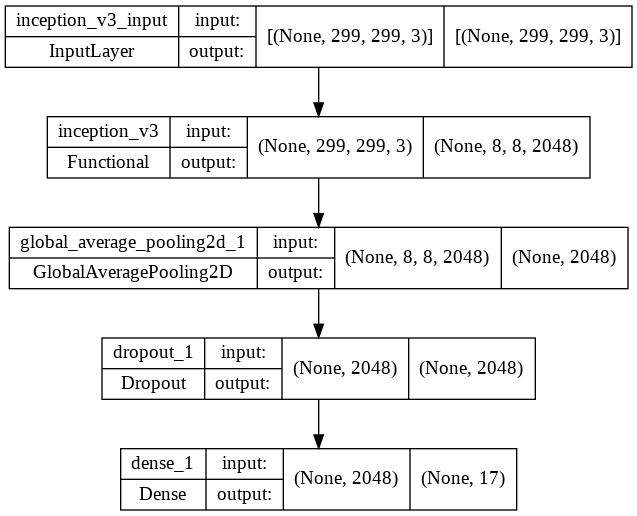

In [ ]:
plot_model (model, 'model.png', show_shapes=True)


In [ ]:
def eval_model(model, test_it):
    # TODO: evaluate the model

    test_loss, test_auc, test_accuracy = model.evaluate (test_it, steps = 27)

    return test_loss, test_auc, test_accuracy

test_loss, test_auc, test_accuracy = eval_model(model, test_it)

27/27 [==============================] - 495s 19s/step - loss: 2.2614 - auc: 0.7969 - accuracy: 0.2753


In [ ]:
test_it.reset()
preds = model.predict(test_it, steps = 27)

In [ ]:
y_predict = np.argmax(preds,axis=1)

In [ ]:
print(classification_report(test_it.classes, y_predict, target_names=test_it.class_indices))

              precision    recall  f1-score   support

        1977       0.21      0.22      0.22       100
       Amaro       0.19      0.07      0.10       100
     Brannan       0.29      0.12      0.17       100
   Clarendon       0.15      0.04      0.06       100
     Gingham       0.16      0.40      0.22       100
       He-Fe       0.23      0.14      0.17       100
      Hudson       0.39      0.21      0.27       100
       Lo-Fi       0.14      0.30      0.19       100
     Mayfair       0.12      0.08      0.10       100
   Nashville       0.37      0.44      0.40       100
    Original       0.31      0.11      0.16       100
    Perpetua       0.16      0.28      0.20       100
       Sutro       0.26      0.28      0.27       100
     Toaster       0.37      0.82      0.51       100
    Valencia       0.17      0.03      0.05       100
      Willow       0.99      0.94      0.96       100
     X-ProII       0.31      0.20      0.24       100

    accuracy              

In [ ]:
y_predict

array([ 0, 11,  0, ..., 13, 12, 12])

In [ ]:
error_count = 0

for x in y_predict:
    if y_predict[x] != test_it.classes[x]:
        error_count += 1
        
error_count

1483

In [ ]:
plot_result(history)


NameError: ignored